In [1]:
import json
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
with open("knowledge_graph_triples_structured.json", 'r', encoding='utf-8') as f:
    knowledge_data = json.load(f)

df_kg = pd.DataFrame(knowledge_data)
df_kg

,id,passage,entities,triples
0,0,ایرانیان از ۱۳۱۶ این دریا را مازندران می‌نامند...,"[ایرانیان, ۱۳۱۶, دریای مازندران, دریای خزر, ۵۰...","[{'subject': 'ایرانیان', 'predicate': 'نام این..."
1,1,پیروزی رونالد ریگان در ابتدای دهه ۱۹۸۰ در حقیق...,"[رونالد ریگان, دهه ۱۹۸۰, جناح راست حزب جمهوری‌...","[{'subject': 'رونالد ریگان', 'predicate': 'پیر..."
2,2,محمد غفاری در خانواده‌ای هنرمند و سرشناس در رو...,"[محمد غفاری, کله, کاشان, ابوتراب غفاری, تهران,...","[{'subject': 'محمد غفاری', 'predicate': 'born ..."
3,3,منطقه گیلان دارای بارش فراوان است تا جایی که ب...,"[گیلان, ۱۲۰ سانتی‌متر, چراغ علی تپه, دهانه گوه...","[{'subject': 'گیلان', 'predicate': 'has annual..."
4,4,فارسی از گذشته‌های دور، به ویژه از دوره یوآن ...,"[فارسی, دوره یوان, سده بیستم, چین, ایران, ساسا...","[{'subject': 'فارسی', 'predicate': 'had import..."
...,...,...,...,...
295,295,دو دوره ریاست جمهوری توماس وودرو ویلسون دموکرا...,"[توماس وودرو ویلسون, دموکرات, جمهوری‌خواهان, ک...","[{'subject': 'توماس وودرو ویلسون', 'predicate'..."
296,296,بعضی از آهنگسازان با استفاده از نت‌های سی بِم...,"[B-flat, A, C, H, BACH, Contrapunctus XIV, Bac...","[{'subject': 'BACH', 'predicate': 'is formed b..."
297,297,در سال ۱۳۵۲ بیمارستان امدادی فاطمیه با مساحت ز...,"[۱۳۵۲, بیمارستان امدادی فاطمیه, ۲۵۰۰ متر, بیما...","[{'subject': 'بیمارستان امدادی فاطمیه', 'predi..."
298,298,میر ظهیرالدین ترکیب این نام را از دو جزء «کوچک...,"[میر ظهیرالدین, عبدالفتاح فومنی, گوراب جور, کو...","[{'subject': 'میر ظهیرالدین', 'predicate': 'ex..."


In [3]:
all_nodes = set()
relation_edges = []

for item in knowledge_data:
    for triple in item['triples']:
        subject = triple['subject'].strip()
        obj = triple['object'].strip()
        
        if subject: all_nodes.add(subject)
        if obj: all_nodes.add(obj)

        relation_edges.append({
            "source": subject,
            "target": obj,
            "type": "relation",
            "label": triple['predicate']
        })


In [4]:
len(relation_edges), len(all_nodes)

(4329, 4691)

In [ ]:
# Collect All Unique Nodes and Relation Edges
nodes_list = sorted(list(all_nodes))
node_to_id = {node: i for i, node in enumerate(nodes_list)}

node_to_id

{'#define max(x, y) ((x)> (y) ? (x) : (y))': 0,
 '+Google': 1,
 '.T.S': 2,
 '1 game': 3,
 '110 نیتروژن atoms': 4,
 '120 نئون atoms': 5,
 '14 درصد': 6,
 '18 درصد': 7,
 '1932': 8,
 '20 میلیون دلار و حکم دادگاه برای اجرای شرایط مجوز': 9,
 '26 درصد جرم خورشید': 10,
 '35 آهن atoms': 11,
 '35 سیلیکون atoms': 12,
 '360 کربن atoms': 13,
 '40 منیزیم atoms': 14,
 '6 ماههٔ اول سال ۹۶': 15,
 '6.4 درصد': 16,
 '70%': 17,
 '72 درصد جرم خورشید': 18,
 '75%': 19,
 '76%': 20,
 '80%': 21,
 '85%': 22,
 '850 اکسیژن atoms': 23,
 '9 weeks': 24,
 '98,000 هلیم atoms': 25,
 'A': 26,
 'ACM': 27,
 'ADA': 28,
 'ADCP': 29,
 'ALGOL ۶۸': 30,
 'APEC': 31,
 'Applied Epistomologist': 32,
 'Applied-Metamathematition': 33,
 'Artašēs': 34,
 'Artaxérxēs': 35,
 'Aşık': 36,
 'Aşıq': 37,
 'Athéisme': 38,
 'B-flat': 39,
 'B3 فسفودی استراز': 40,
 'BACH': 41,
 'Bach': 42,
 "Bach's devotion to Jesus Christ": 43,
 'Bell Labs': 44,
 'Beta': 45,
 'British philosopher and anthropologist': 46,
 'C': 47,
 'C با کلاس': 48,
 'C++'

# Extracting Node Similarity and filtering

In [6]:
## mps or cpu
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"device: {device}")
encode_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')


device: mps


In [7]:

node_embeddings = encode_model.encode(
    nodes_list, 
    show_progress_bar=True,
    convert_to_tensor=True
)

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

In [8]:
# Find Similar Nodes and Create Synonymy Edges 

similar_pairs = util.paraphrase_mining_embeddings(
    node_embeddings,
    top_k=2, 
)

SIMILARITY_THRESHOLD = 0.96

synonymy_edges = []
for score, i, j in similar_pairs:
    if score > SIMILARITY_THRESHOLD:
        node1 = nodes_list[i]
        node2 = nodes_list[j]
        synonymy_edges.append({
            "source": node1,
            "target": node2,
            "type": "synonymy",
            "score": score
        })


In [9]:
final_graph = {
    "nodes": [{"id": i, "label": node} for i, node in enumerate(nodes_list)],
    "edges": relation_edges + synonymy_edges
}

In [10]:
with open("hippocampal_index.json", 'w', encoding='utf-8') as f:
    json.dump(final_graph, f, ensure_ascii=False, indent=4)


# PPR

In [11]:
import json
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np
import igraph as ig
from tqdm import tqdm
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List
import dotenv
import os

dotenv.load_dotenv()


GRAPH_INDEX_PATH = "hippocampal_index.json"
SOURCE_TRIPLES_PATH = "knowledge_graph_triples_structured.json"
ORIGINAL_CONTEXT_PATH = "all_context.json"
ENCODER_MODEL_NAME = 'paraphrase-multilingual-MiniLM-L12-v2'
MODEL_NAME = "gpt-4o-mini"
PPR_DAMPING_FACTOR = 0.5 # The lesser the value, the more the algorithm focuses on the local structure of the graph.

In [ ]:
class QueryEntities(BaseModel):
    named_entities: List[str] = Field(
        ...,
        description="A list of named entities that are important for solving the user's question."
    )


class HippoRAGRetriever:
    def __init__(self):
        print("Initializing HippoRAGRetriever...")
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self._load_data()

        self.encoder_model = SentenceTransformer(ENCODER_MODEL_NAME, device=self.device)
        self.llm = ChatOpenAI(
            model=MODEL_NAME, temperature=0, api_key=os.getenv("METIS_API_KEY"), base_url="https://api.metisai.ir/openai/v1"
        )
        
        # Pre-compute necessary mappings and structures
        self._build_graph()
        self._compute_node_specificity()
        self._create_passage_to_node_mapping()

        # Pre-encode all graph nodes for fast query-time similarity search
        print("Pre-encoding all graph nodes for retrieval...")
        self.node_labels = [node['label'] for node in self.graph_data['nodes']]
        self.node_embeddings = self.encoder_model.encode(
            self.node_labels, show_progress_bar=True, convert_to_tensor=True
        )
        print("Initialization complete.")

    def _load_data(self):
        print("Loading graph index and source data...") ## DEBUG
        try:
            with open(GRAPH_INDEX_PATH, 'r', encoding='utf-8') as f:
                self.graph_data = json.load(f)
            with open(SOURCE_TRIPLES_PATH, 'r', encoding='utf-8') as f:
                self.source_triples = json.load(f)
            with open(ORIGINAL_CONTEXT_PATH, 'r', encoding='utf-8') as f:
                self.passages = json.load(f) 
        except FileNotFoundError as e:
            print(f"Error: Could not find a file: {e.filename}")
            exit()

    def _build_graph(self):
        print("Building weighted igraph object...") ## DEBUG
        self.g = ig.Graph(directed=False)
        self.g.add_vertices(len(self.graph_data['nodes']))
        
        self.node_label_to_id = {node['label']: node['id'] for node in self.graph_data['nodes']}
        
        edges = []
        weights = []
        for edge_data in self.graph_data['edges']:
            source_id = self.node_label_to_id.get(edge_data['source'])
            target_id = self.node_label_to_id.get(edge_data['target'])
            
            if source_id is not None and target_id is not None:
                edges.append((source_id, target_id))
                # Assign weights: similarity score for synonymy, 1.0 for relations
                if edge_data['type'] == 'synonymy':
                    weights.append(edge_data.get('score', 0.8))
                else: 
                    weights.append(1.0)
        
        self.g.add_edges(edges)
        # Assign the weights to the 'weight' edge attribute
        self.g.es['weight'] = weights  
        print(f"Graph built with {self.g.vcount()} vertices and {self.g.ecount()} edges.")

    def _compute_node_specificity(self):
        """
        Specificity s_i = 1 / |P_i|
        """
        print("Computing node specificity...")
        node_passage_counts = {node_id: 0 for node_id in range(len(self.node_label_to_id))}
        passage_nodes = {} 
        for item in self.source_triples:
            passage_id = item['id']
            nodes_in_passage = set(item.get('entities', []))
            for triple in item.get('triples', []):
                nodes_in_passage.add(triple['subject'])
                nodes_in_passage.add(triple['object'])
            
            for node_label in nodes_in_passage:
                node_id = self.node_label_to_id.get(node_label)
                if node_id is not None:
                    if passage_id not in passage_nodes.get(node_id, set()):
                        node_passage_counts[node_id] += 1
                        if node_id not in passage_nodes:
                            passage_nodes[node_id] = set()
                        passage_nodes[node_id].add(passage_id)

        self.node_specificity = {}
        for node_id, count in node_passage_counts.items():
            if count > 0:
                self.node_specificity[node_id] = 1.0 / count
            else:
                self.node_specificity[node_id] = 0

    def _create_passage_to_node_mapping(self):
        self.passage_to_nodes = {i: [] for i in range(len(self.passages))}
        for item in self.source_triples:
            passage_idx = item['id']
            nodes_in_passage = set(item.get('entities', []))
            for triple in item.get('triples', []):
                nodes_in_passage.add(triple['subject'])
                nodes_in_passage.add(triple['object'])
            
            node_ids_in_passage = {self.node_label_to_id.get(label) for label in nodes_in_passage}
            self.passage_to_nodes[passage_idx] = [nid for nid in node_ids_in_passage if nid is not None]


    def _extract_query_entities(self, query: str) -> List[str]:
        system_prompt = """
        Instruction:
        Your task is to extract named entities from the given paragraph in the user's message.
        Respond with a JSON list of entities.

        One-Shot Demonstration:
        If the user provides the paragraph:
        "Radio City is India's first private FM radio station and was started on 3 July 2001. It plays Hindi, English and regional songs. Radio City recently forayed into New Media in May 2008 with the launch of a music portal - PlanetRadiocity.com that offers music related news, videos, songs, and other music-related features."

        Your output should be a JSON object with a list of the extracted entities:
        {{"named_entities": ["Radio City", "India", "3 July 2001", "Hindi", "English", "May 2008", "PlanetRadiocity.com"]}}
        """
        prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("human", "Question: {query}")
        ])
        chain = prompt | self.llm.with_structured_output(QueryEntities)
        try:
            response = chain.invoke({"query": query})
            return response.named_entities
        except Exception as e:
            print(f"Error extracting query entities: {e}")
            return []
            
    def _find_query_nodes(self, query_entities: List[str]) -> List[int]:
        if not query_entities:
            return []
        
        global VERBOSE
        
        query_embeddings = self.encoder_model.encode(query_entities, convert_to_tensor=True)
        cos_scores = util.cos_sim(query_embeddings, self.node_embeddings)
        
        top_matches_indices = torch.argmax(cos_scores, dim=1)
        
        ########### DEBUGGING
        matched_node_ids = []
        for i, entity in enumerate(query_entities):
            node_id = top_matches_indices[i].item()
            score = cos_scores[i][node_id].item()
            node_label = self.node_labels[node_id]
            if VERBOSE:
                print(f"  - Query Entity: '{entity}' -> Matched Node: '{node_label}' (ID: {node_id}) | Score: {score:.4f}")
            matched_node_ids.append(node_id)
        ########### 
            
        
        return list(set(matched_node_ids))

    def retrieve(self, query: str, top_k: int = 5) -> List[dict]:
        """
        Performs the full online retrieval process for a given query.
        """
        global VERBOSE
        
        # 1. Neocortex: Extract entities from query
        query_entities = self._extract_query_entities(query)
        if not query_entities:
            print("Could not extract entities from query. Aborting retrieval.")
            return []
        if VERBOSE:
            print(f"Step 1: Extracted query entities -> {query_entities}")

        # 2. Parahippocampal Regions: Find corresponding nodes in the graph
        query_node_ids = self._find_query_nodes(query_entities)
        if not query_node_ids:
            print("Could not find matching nodes in the graph. Aborting retrieval.")
            return []
        query_node_labels = [self.node_labels[i] for i in query_node_ids]
        if VERBOSE:
            print(f"Step 2: Found corresponding query nodes -> {query_node_labels}")

        # 3. Hippocampus: Perform pattern completion with PPR
        personalization_vector = np.zeros(self.g.vcount())
        total_specificity = 0
        for node_id in query_node_ids:
            specificity = self.node_specificity.get(node_id, 0)
            personalization_vector[node_id] = specificity
            total_specificity += specificity
        
        if total_specificity > 0:
            personalization_vector /= total_specificity
            
        ppr_scores = self.g.personalized_pagerank(
            vertices=None,
            directed=False,
            damping=PPR_DAMPING_FACTOR,
            reset=personalization_vector.tolist(),
            weights=self.g.es['weight']  # Use the edge weights for calculation
        )

        ########### DEBUGGING        
        if VERBOSE:
            print("\n--- DEBUG: Top 10 Nodes after PageRank ---")
            # Get the indices of the top 10 scores
            top_node_indices = np.argsort(ppr_scores)[-10:][::-1]
            for node_id in top_node_indices:
                print(f"  - Node: '{self.node_labels[node_id]}' (ID: {node_id}) | PPR Score: {ppr_scores[node_id]:.6f}")
        
        # 4. Aggregate node scores to get passage scores
        passage_scores = {i: 0.0 for i in range(len(self.passages))}
        for passage_idx, node_ids in self.passage_to_nodes.items():
            score = sum(ppr_scores[node_id] for node_id in node_ids)
            passage_scores[passage_idx] = score
            
        # Sort and return top_k results
        sorted_passages = sorted(passage_scores.items(), key=lambda item: item[1], reverse=True)
        
        results = []
        for passage_idx, score in sorted_passages[:top_k]:
            results.append({
                "passage_index": passage_idx,
                "passage_text": self.source_triples[passage_idx]["passage"],
                "score": score
            })
        return results

In [13]:
retriever = HippoRAGRetriever()

Initializing HippoRAGRetriever...
Loading graph index and source data...
Building weighted igraph object...
Graph built with 4691 vertices and 4649 edges.
Computing node specificity...
Pre-encoding all graph nodes for retrieval...


Batches:   0%|          | 0/147 [00:00<?, ?it/s]

Initialization complete.


In [ ]:
example_query = "در چه سالی استفاده از واژه اینترنت معمول شد و مجازا برای اشاره به وب هم استفاده شد؟"
VERBOSE = True
top_passages = retriever.retrieve(query=example_query, top_k=15)

print("\n--- Top 5 Retrieved Passages ---")
for i, result in enumerate(top_passages):
    print(f"{i+1}. [Score: {result['score']:.6f}] Passage (Index {result['passage_index']}):")
    print(f"   '{result['passage_text'][:200]}...'")
    print("-" * 20)

Step 1: Extracted query entities -> ['اینترنت', 'وب']
  - Query Entity: 'اینترنت' -> Matched Node: 'اینترنت' (ID: 880) | Score: 1.0000
  - Query Entity: 'وب' -> Matched Node: 'مایکروسافت' (ID: 3012) | Score: 0.9117
Step 2: Found corresponding query nodes -> ['اینترنت', 'مایکروسافت']

--- DEBUG: Top 10 Nodes after PageRank ---
  - Node: 'مایکروسافت' (ID: 3012) | PPR Score: 0.555556
  - Node: 'ویندوز ارسال نمی کند' (ID: 3711) | PPR Score: 0.277778
  - Node: 'اینترنت' (ID: 880) | PPR Score: 0.101955
  - Node: 'VoIP' (ID: 113) | PPR Score: 0.006498
  - Node: 'Internet' (ID: 82) | PPR Score: 0.005004
  - Node: 'تلفن اینترنتی' (ID: 1238) | PPR Score: 0.004247
  - Node: '۱۹۹۷' (ID: 4467) | PPR Score: 0.004191
  - Node: 'دهه ۹۰' (ID: 1805) | PPR Score: 0.004191
  - Node: 'more effective collaboration than any other method' (ID: 195) | PPR Score: 0.003922
  - Node: 'انتشار ارزان و سریع نرم‌افزار' (ID: 719) | PPR Score: 0.003922

--- Top 5 Retrieved Passages ---
1. [Score: 0.834344] Passage (Ind

# RAG pipeline

In [ ]:
class StructuredAnswer(BaseModel):
    final_answer: str = Field(
        description="The final, concise answer to the user's question."
    )

In [ ]:
class QuestionAnsweringSystem:
    def __init__(self, retriever: HippoRAGRetriever):
        self.retriever = retriever
        self.llm = ChatOpenAI(
             model="gpt-4o-mini", temperature=0, api_key=os.getenv("METIS_API_KEY"), base_url="https://api.metisai.ir/openai/v1"
        )
        self.qa_prompt = self._create_qa_prompt()

    def _create_qa_prompt(self):        
        system_prompt = f"""
        You are an expert Question Answering assistant. Your task is to answer the user's question based *only* on the provided context.
        First, think step-by-step.
        Then, provide a clear and very concise final answer. The answer should be a direct value.

        --- ONE-SHOT EXAMPLE ---
        CONTEXT:
        Passage 1: The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower.
        Passage 2: The construction of the Eiffel Tower began in January 1887 and was completed on 31 March 1889.

        QUESTION:
        When was the Eiffel Tower finished?

        YOUR STRUCTURED OUTPUT:
        {{{{
            "final_answer": "31 March 1889"
        }}}}
        --- END OF EXAMPLE ---
        """

        return ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("human", "CONTEXT:\n{context}\n\nQUESTION:\n{question}\n\nYOUR STRUCTURED OUTPUT:")
        ])

    def answer_question(self, query: str, top_k_retrieval: int = 5) -> str:
        # Retrieve relevant passages using HippoRAG
        retrieved_passages = self.retriever.retrieve(query, top_k=top_k_retrieval)
        
        if not retrieved_passages:
            print("No relevant context found. Cannot generate an answer.")
            return "Could not find any relevant information to answer the question."

        context_string = ""
        for i, doc in enumerate(retrieved_passages):
            context_string += f"Passage {i+1} (Score: {doc['score']:.4f}):\n{doc['passage_text']}\n\n"
        
        structured_chain = self.qa_prompt | self.llm.with_structured_output(StructuredAnswer)
        
        try:
            response = structured_chain.invoke({
                "context": context_string.strip(),
                "question": query
            })
            return response.final_answer
        except Exception as e:
            print(f"Failed to generate answer: {e}")
            return "Failed to generate answer from the context."

In [23]:
qa_system = QuestionAnsweringSystem(retriever=retriever)

In [24]:
VERBOSE = False
example_query = "در چه سالی استفاده از واژه اینترنت معمول شد و مجازا برای اشاره به وب هم استفاده شد؟"
final_answer = qa_system.answer_question(example_query, top_k_retrieval=5)

print(final_answer)


دهه ۹۰


In [ ]:
df_test = pd.read_csv('pquad_questions.csv')
df_test.head()

,question,answer,id,context_id
0,ساختار آب چیست؟,اکسید هیدروژن,1624917,114
1,اکسیژن با کدام عناصر در دماهای بالا پیوند شیمی...,تقریباً با تمام عناصر,1624977,114
2,رضاخان دوران جنگ جهانی را بیشتر در کدام سمت ای...,غرب,1637359,123
3,روس‌های سفید که بودند؟,NaN,1637429,123
4,از بزرگان خوانین شهریار نام چه کسانی را می‌توا...,کدخدا حسینقلی زند و فرزند ایشان باقرخان زند,1602784,101


In [26]:
results_no_reasoning = []
for i in tqdm(range(len(df_test))):
    row = df_test.iloc[i]
    question = row['question']
    answer = row['answer']
    model_answer = qa_system.answer_question(question, top_k_retrieval=10)
    results_no_reasoning.append({'question': question, 'answer': answer, 'model_answer': model_answer})
    

# save results
with open('results_no_reasoning.json', 'w', encoding='utf-8') as f:
    json.dump(results_no_reasoning, f, ensure_ascii=False, indent=4)

  0%|          | 1/500 [00:00<05:19,  1.56it/s]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:31<15:55,  2.04s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 41/500 [01:52<14:55,  1.95s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:53<12:01,  1.58s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 12%|█▏        | 59/500 [02:33<15:18,  2.08s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [03:00<12:46,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 16%|█▋        | 82/500 [03:27<12:26,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 19%|█▉        | 94/500 [03:56<14:57,  2.21s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [04:38<18:10,  2.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [05:03<20:09,  3.13s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 117/500 [05:08<13:09,  2.06s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [05:33<14:13,  2.28s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [06:02<15:42,  2.60s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [06:33<11:25,  1.97s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 35%|███▌      | 177/500 [07:36<09:42,  1.80s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [07:42<09:17,  1.74s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [07:53<09:59,  1.90s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [08:32<09:30,  1.92s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [08:33<08:05,  1.63s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [08:58<09:12,  1.94s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [09:58<10:20,  2.38s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 240/500 [09:59<08:31,  1.97s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [10:13<08:10,  1.93s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [10:49<08:23,  2.11s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 61%|██████▏   | 307/500 [12:36<06:04,  1.89s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 64%|██████▍   | 322/500 [13:10<05:43,  1.93s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▌   | 328/500 [13:22<05:03,  1.76s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [13:32<05:48,  2.07s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [16:01<04:13,  2.33s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 80%|████████  | 402/500 [16:31<03:57,  2.43s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [16:36<02:51,  1.81s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 84%|████████▎ | 418/500 [17:09<03:19,  2.44s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [17:36<02:19,  1.99s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 87%|████████▋ | 433/500 [17:42<01:58,  1.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [17:53<02:05,  2.03s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 442/500 [18:01<01:49,  1.88s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [18:02<01:31,  1.61s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 445/500 [18:05<01:26,  1.57s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 460/500 [18:39<01:18,  1.96s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [19:09<00:52,  1.96s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [19:16<00:39,  1.73s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 99%|█████████▉| 496/500 [19:58<00:07,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


100%|██████████| 500/500 [20:07<00:00,  2.42s/it]


# Evaluateate the results using LLM judge

In [27]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List, Dict, Any
import json
import re
from tqdm import tqdm


In [ ]:
# load the results
with open('results_no_reasoning.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

In [29]:
results

[{'question': 'ساختار آب چیست؟',
  'answer': 'اکسید هیدروژن',
  'model_answer': 'Could not find any relevant information to answer the question.'},
 {'question': 'اکسیژن با کدام عناصر در دماهای بالا پیوند شیمیایی تشکیل می\u200cدهد؟',
  'answer': 'تقریباً با تمام عناصر',
  'model_answer': 'هیدروژن (H۲) و هلیم (He)'},
 {'question': 'رضاخان دوران جنگ جهانی را بیشتر در کدام سمت ایران سپری کرد؟',
  'answer': 'غرب',
  'model_answer': 'غرب ایران'},
 {'question': 'روس\u200cهای سفید که بودند؟',
  'answer': nan,
  'model_answer': 'روس\u200cهای سفید به گروهی از نیروهای ضد بلشویک در جنگ داخلی روسیه اشاره دارند.'},
 {'question': 'از بزرگان خوانین شهریار نام چه کسانی را می\u200cتوان برد؟',
  'answer': 'کدخدا حسینقلی زند و فرزند ایشان باقرخان زند',
  'model_answer': ''},
 {'question': 'چهار پرچم یافت\u200cشده در کتیبه\u200cهای سنگی دوران ساسانی نماد چه هستند؟',
  'answer': 'سلطنتی و اشراف\u200cزادگی',
  'model_answer': 'سلطنتی و اشراف\u200cزادگی'},
 {'question': 'محصولات صادراتی ژاپن چیست؟',
  'answe

In [ ]:
class AnswerEvaluation(BaseModel):
    is_correct: bool = Field(description="True if the model answer is semantically equivalent to the correct answer, False otherwise")

llm_judge = ChatOpenAI(
    model="gpt-4o-mini",  
    temperature=0.1,  
    max_tokens=500,
    api_key=os.getenv("METIS_API_KEY"),
    base_url='https://api.metisai.ir/openai/v1',
).with_structured_output(AnswerEvaluation)

def clean_model_answer(model_answer: str) -> str:
    cleaned = re.sub(r'<ANSWER>(.*?)</ANSWER>', r'\1', model_answer, flags=re.DOTALL)
    return cleaned.strip()

def evaluate_single_answer(question: str, correct_answer: str, model_answer: str) -> AnswerEvaluation:
    # Create the evaluation prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert judge evaluating Persian/Farsi question-answer pairs. 
        Your task is to determine if the model's answer is semantically equivalent to the correct answer.

        Consider these factors:
        - Semantic similarity (same meaning, different wording)
        - Spelling variations and Persian writing differences
        - Different but equivalent expressions (e.g., "بله" vs "بلی", both mean "yes")
        - Context and cultural nuances in Persian language
        - Both answers should convey the same factual information

        Be strict but fair - minor spelling differences or equivalent expressions should be considered correct.
        Only mark as incorrect if the meaning is genuinely different or wrong."""),
                
        ("user", """Question: {question}
        Correct Answer: {correct_answer}
        Model Answer: {model_answer}

        Evaluate if the model answer is semantically equivalent to the correct answer.""")
    ])
    
    messages = prompt.format_messages(
        question=question,
        correct_answer=correct_answer,
        model_answer=model_answer
    )
    
    try:
        evaluation = llm_judge.invoke(messages)
        return evaluation
    except Exception as e:
        return AnswerEvaluation(
            is_correct=False,
            reasoning=f"API call failed: {str(e)}"
        )




In [ ]:
evaluated_results = []
for item in tqdm(results, desc="Evaluating answers"):
    
    question = item['question']
    correct_answer = item['answer']
    model_answer = item['model_answer']
    # item_id = item['id']
    
    # Get evaluation from LLM judge
    evaluation = evaluate_single_answer(question, correct_answer, model_answer)
    
    evaluated_item = {
        **item,
        'clean_model_answer': model_answer,
        'is_correct': evaluation.is_correct,
    }
    
    evaluated_results.append(evaluated_item)

df = pd.DataFrame(evaluated_results)
# save to csv file
df.to_csv('evaluated_results_no_reasoning_RAG.csv', index=False)

Evaluating answers: 100%|██████████| 500/500 [07:57<00:00,  1.05it/s]


In [32]:
df.is_correct.mean()

0.34

# change the number of retrieved documents

In [33]:
num_retrieved = [1, 2, 3, 5, 7, 10, 15, 25]

results_no_reasoning = {}
for num in num_retrieved:
    # do the same as above but with num retrieved documents
    # save the results to a csv file with the name evaluated_results_num_retrieved_{num}.csv
    
    results_no_reasoning[num] = []
    for i in tqdm(range(len(df_test))):
        row = df_test.iloc[i]
        question = row['question']
        answer = row['answer']
        model_answer = qa_system.answer_question(question, top_k_retrieval=num)
        results_no_reasoning[num].append({'question': question, 'answer': answer, 'model_answer': model_answer})
        
# save results
with open(f'results_no_reasoning_different_numbers.json', 'w', encoding='utf-8') as f:
    json.dump(results_no_reasoning, f, ensure_ascii=False, indent=4)

  0%|          | 1/500 [00:03<25:12,  3.03s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:29<17:56,  2.30s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 41/500 [01:58<21:17,  2.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:59<17:14,  2.26s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 12%|█▏        | 59/500 [02:53<20:35,  2.80s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [03:34<20:03,  2.81s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 16%|█▋        | 82/500 [04:16<17:35,  2.53s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 20%|██        | 100/500 [05:25<29:37,  4.44s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [05:42<16:39,  2.54s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [06:04<17:29,  2.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [06:32<13:11,  2.12s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [07:01<13:16,  2.19s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|██▉       | 148/500 [07:30<15:39,  2.67s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [07:37<13:16,  2.28s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 35%|███▍      | 173/500 [08:42<11:57,  2.20s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [09:01<13:10,  2.47s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [09:13<10:33,  2.01s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [10:02<11:59,  2.42s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [10:02<09:38,  1.95s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [10:35<10:32,  2.22s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [11:40<11:34,  2.66s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [12:01<11:11,  2.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [12:46<11:43,  2.94s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▌   | 328/500 [15:45<05:17,  1.85s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [15:56<06:40,  2.38s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [18:26<03:45,  2.07s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [19:11<04:31,  2.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 84%|████████▎ | 418/500 [19:51<04:00,  2.93s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [20:23<02:37,  2.25s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 87%|████████▋ | 433/500 [20:36<03:23,  3.04s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [20:50<02:43,  2.63s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 441/500 [20:57<02:14,  2.29s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [21:00<01:45,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 445/500 [21:05<01:52,  2.05s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 459/500 [21:45<01:35,  2.32s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [22:29<01:06,  2.47s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [22:39<00:54,  2.35s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 97%|█████████▋| 484/500 [23:01<00:41,  2.61s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 97%|█████████▋| 485/500 [23:02<00:31,  2.10s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 99%|█████████▉| 496/500 [23:36<00:09,  2.49s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  0%|          | 1/500 [00:00<08:15,  1.01it/s]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:30<19:30,  2.50s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 41/500 [01:53<16:06,  2.11s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:54<13:33,  1.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 12%|█▏        | 59/500 [02:43<18:59,  2.58s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [03:17<15:10,  2.12s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 16%|█▋        | 82/500 [03:49<18:43,  2.69s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 20%|██        | 100/500 [04:41<19:05,  2.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [04:59<15:48,  2.41s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [05:18<13:45,  2.14s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [05:53<14:01,  2.25s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [06:20<14:00,  2.32s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [06:59<14:33,  2.50s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 33%|███▎      | 163/500 [07:24<10:38,  1.89s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 35%|███▍      | 173/500 [07:53<14:39,  2.69s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [08:09<12:08,  2.28s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [08:24<13:12,  2.52s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [09:12<10:09,  2.04s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [09:50<11:46,  2.48s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [11:03<11:31,  2.65s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 240/500 [11:04<09:22,  2.16s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [11:23<11:10,  2.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [12:10<10:08,  2.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 53%|█████▎    | 263/500 [12:15<09:30,  2.41s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▌   | 328/500 [15:27<07:30,  2.62s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [15:38<06:54,  2.47s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 68%|██████▊   | 342/500 [16:09<07:08,  2.71s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [18:32<04:27,  2.45s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 80%|████████  | 402/500 [19:03<03:55,  2.40s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [19:11<03:48,  2.41s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 83%|████████▎ | 417/500 [19:41<03:07,  2.26s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 84%|████████▎ | 418/500 [19:42<02:34,  1.88s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [20:17<02:59,  2.57s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 87%|████████▋ | 433/500 [20:25<02:50,  2.54s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [20:39<02:33,  2.48s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [20:51<02:05,  2.20s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 445/500 [20:55<01:50,  2.01s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 447/500 [20:59<01:41,  1.92s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 459/500 [21:29<01:32,  2.26s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 460/500 [21:30<01:14,  1.87s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [22:08<01:14,  2.75s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [22:16<00:46,  2.03s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 97%|█████████▋| 484/500 [22:35<00:38,  2.40s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:23<15:07,  1.94s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 41/500 [01:48<18:12,  2.38s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:50<16:54,  2.22s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 12%|█▏        | 59/500 [02:40<16:57,  2.31s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [03:13<14:31,  2.03s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [04:54<13:09,  2.01s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [05:14<13:51,  2.15s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 117/500 [05:19<11:20,  1.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [05:41<12:19,  1.98s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [06:11<14:23,  2.38s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [06:51<13:37,  2.34s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 32%|███▏      | 160/500 [07:16<13:16,  2.34s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 34%|███▍      | 172/500 [07:48<13:54,  2.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 35%|███▍      | 173/500 [07:48<10:39,  1.96s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [08:02<09:32,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [08:10<07:48,  1.49s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 38%|███▊      | 188/500 [08:15<07:56,  1.53s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [08:47<08:55,  1.80s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [09:17<11:48,  2.48s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [10:06<07:47,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 240/500 [10:07<06:43,  1.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [10:19<07:25,  1.75s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 64%|██████▍   | 322/500 [13:07<06:04,  2.05s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▌   | 328/500 [13:19<04:51,  1.69s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [13:25<04:17,  1.53s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 68%|██████▊   | 342/500 [13:45<04:21,  1.66s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [15:35<06:22,  3.51s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 80%|████████  | 402/500 [16:01<03:13,  1.97s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [16:08<02:57,  1.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 84%|████████▎ | 418/500 [16:35<02:10,  1.59s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [16:59<02:09,  1.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 87%|████████▋ | 433/500 [17:04<01:50,  1.65s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [17:12<01:35,  1.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 441/500 [17:17<01:31,  1.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [17:21<01:33,  1.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 445/500 [17:24<01:18,  1.43s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 459/500 [17:52<01:13,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 460/500 [17:53<00:59,  1.48s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [18:19<00:51,  1.90s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [18:25<00:35,  1.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 97%|█████████▋| 484/500 [18:38<00:26,  1.63s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 99%|█████████▉| 496/500 [19:05<00:09,  2.25s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  0%|          | 1/500 [00:00<05:44,  1.45it/s]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:06<14:09,  1.82s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  7%|▋         | 33/500 [01:07<11:25,  1.47s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:27<13:59,  1.83s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [02:32<17:46,  2.49s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 16%|█▋        | 82/500 [02:54<11:10,  1.60s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 20%|██        | 100/500 [03:33<10:04,  1.51s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [03:56<13:48,  2.11s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [04:08<10:40,  1.66s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [04:34<10:11,  1.63s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 26%|██▌       | 130/500 [04:41<09:52,  1.60s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [04:56<10:33,  1.74s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [05:31<13:44,  2.36s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 34%|███▍      | 172/500 [06:13<08:57,  1.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 35%|███▍      | 173/500 [06:14<07:36,  1.40s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [06:29<10:49,  2.03s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [06:38<08:37,  1.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 38%|███▊      | 188/500 [06:45<10:18,  1.98s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [07:15<08:43,  1.76s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [07:16<07:18,  1.48s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [07:42<08:49,  1.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [08:34<07:39,  1.76s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [08:50<09:24,  2.22s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [09:21<06:26,  1.62s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 61%|██████▏   | 307/500 [11:02<06:39,  2.07s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [12:01<05:22,  1.92s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [14:03<03:32,  1.95s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [14:34<02:43,  1.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 84%|████████▎ | 418/500 [15:05<02:43,  1.99s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [15:31<02:12,  1.89s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 87%|████████▋ | 433/500 [15:35<01:43,  1.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [15:44<01:30,  1.47s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 441/500 [15:49<01:27,  1.48s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [15:51<01:19,  1.40s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 447/500 [15:58<01:15,  1.43s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 459/500 [16:22<01:12,  1.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [16:50<00:44,  1.65s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [16:57<00:35,  1.52s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 97%|█████████▋| 484/500 [17:09<00:24,  1.52s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 99%|█████████▉| 496/500 [17:33<00:06,  1.62s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  0%|          | 1/500 [00:01<09:02,  1.09s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:04<13:35,  1.74s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 38/500 [01:17<14:08,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 41/500 [01:22<11:47,  1.54s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:22<10:12,  1.34s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 12%|█▏        | 59/500 [01:56<12:57,  1.76s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [02:23<17:17,  2.42s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 16%|█▋        | 82/500 [02:52<13:00,  1.87s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [03:48<09:45,  1.49s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [04:03<11:33,  1.80s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 117/500 [04:08<09:46,  1.53s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [04:26<10:40,  1.71s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 26%|██▌       | 130/500 [04:33<09:57,  1.61s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [04:46<09:33,  1.58s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [05:15<11:02,  1.90s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 35%|███▌      | 177/500 [06:07<08:53,  1.65s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [06:12<08:32,  1.60s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [06:21<08:33,  1.63s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 38%|███▊      | 188/500 [06:26<08:15,  1.59s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [06:55<09:15,  1.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [06:56<07:40,  1.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [07:20<08:06,  1.71s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [08:15<08:39,  1.99s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 240/500 [08:16<07:05,  1.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [08:27<06:44,  1.59s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 51%|█████     | 254/500 [08:45<09:49,  2.40s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [09:01<07:58,  2.00s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▌   | 328/500 [11:23<05:03,  1.76s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [11:31<05:20,  1.91s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 68%|██████▊   | 342/500 [11:52<04:36,  1.75s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 72%|███████▏  | 358/500 [12:28<03:43,  1.58s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [13:42<03:21,  1.85s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [14:13<03:10,  2.00s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 84%|████████▎ | 418/500 [14:45<02:31,  1.85s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 429/500 [15:10<02:49,  2.38s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [15:11<02:23,  2.05s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [15:27<01:45,  1.70s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 441/500 [15:32<01:28,  1.50s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [15:34<01:16,  1.35s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 447/500 [15:41<01:20,  1.53s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 459/500 [16:11<01:16,  1.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [16:45<00:52,  1.96s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [16:52<00:37,  1.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 97%|█████████▋| 484/500 [17:05<00:28,  1.75s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 99%|█████████▉| 496/500 [17:32<00:07,  1.95s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  0%|          | 1/500 [00:00<07:27,  1.12it/s]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:07<16:03,  2.06s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 41/500 [01:26<13:40,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:27<11:07,  1.46s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 12%|█▏        | 59/500 [02:04<12:19,  1.68s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [02:30<13:03,  1.83s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 19%|█▉        | 94/500 [03:19<12:44,  1.88s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 20%|██        | 100/500 [03:30<10:35,  1.59s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [03:42<09:53,  1.51s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [03:55<10:37,  1.65s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [04:22<11:47,  1.89s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [04:45<11:41,  1.93s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [05:14<10:20,  1.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 34%|███▍      | 172/500 [05:59<09:25,  1.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [06:16<10:46,  2.02s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [06:26<08:58,  1.71s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [07:06<09:59,  2.01s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [07:07<08:38,  1.74s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [07:31<07:25,  1.56s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [08:22<08:01,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 240/500 [08:24<07:26,  1.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [08:39<10:05,  2.38s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [09:16<09:07,  2.29s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 61%|██████▏   | 307/500 [10:57<05:33,  1.73s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▌   | 328/500 [11:41<05:09,  1.80s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [11:48<04:15,  1.52s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 72%|███████▏  | 358/500 [12:42<03:49,  1.62s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [13:51<03:05,  1.70s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [14:19<02:34,  1.62s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 83%|████████▎ | 417/500 [14:44<02:37,  1.90s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [15:14<02:04,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 87%|████████▋ | 433/500 [15:19<01:48,  1.62s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [15:29<01:47,  1.73s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 441/500 [15:35<01:40,  1.70s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [15:39<01:44,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 445/500 [15:44<01:53,  2.06s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 459/500 [16:15<01:07,  1.65s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 460/500 [16:16<00:55,  1.40s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [16:44<00:51,  1.90s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [16:51<00:38,  1.66s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 97%|█████████▋| 484/500 [17:09<00:32,  2.05s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:13<14:43,  1.89s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:38<14:56,  1.96s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [02:46<11:55,  1.67s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 20%|██        | 100/500 [03:50<11:37,  1.74s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [04:02<10:44,  1.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [04:17<11:07,  1.73s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 117/500 [04:24<12:36,  1.98s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [04:45<11:26,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [05:09<12:33,  2.08s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [05:37<10:31,  1.81s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 33%|███▎      | 163/500 [06:05<12:26,  2.21s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 35%|███▍      | 173/500 [06:29<11:09,  2.05s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [06:43<09:26,  1.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [06:51<08:00,  1.53s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 38%|███▊      | 188/500 [06:56<07:25,  1.43s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [07:27<09:14,  1.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [07:28<07:44,  1.56s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [07:53<09:20,  1.97s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [08:53<09:08,  2.10s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 240/500 [08:54<07:22,  1.70s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [09:08<08:17,  1.96s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 51%|█████     | 254/500 [09:26<09:44,  2.38s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [09:43<08:17,  2.08s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 60%|█████▉    | 298/500 [11:40<07:54,  2.35s/it]


KeyboardInterrupt: 

In [35]:
results_no_reasoning.keys()

dict_keys([1, 2, 3, 5, 7, 10, 15])

In [ ]:
# with open(f'results_no_reasoning_different_numbers_1_to_10.json', 'w', encoding='utf-8') as f:
#     json.dump(results_no_reasoning, f, ensure_ascii=False, indent=4)

In [ ]:
for num in num_retrieved:
    # do the same as above but with num retrieved documents
    if num < 15:
        continue
    results_no_reasoning[num] = []
    for i in tqdm(range(len(df_test))):
        row = df_test.iloc[i]
        question = row['question']
        answer = row['answer']
        model_answer = qa_system.answer_question(question, top_k_retrieval=num)
        results_no_reasoning[num].append({'question': question, 'answer': answer, 'model_answer': model_answer})
        
with open(f'results_no_reasoning_different_numbers.json', 'w', encoding='utf-8') as f:
    json.dump(results_no_reasoning, f, ensure_ascii=False, indent=4)

  0%|          | 1/500 [00:00<07:18,  1.14it/s]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:09<13:11,  1.69s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 41/500 [01:27<13:09,  1.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:27<10:53,  1.43s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 16%|█▋        | 82/500 [02:53<11:19,  1.63s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 20%|██        | 100/500 [03:35<11:59,  1.80s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [03:48<10:03,  1.54s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 22%|██▏       | 111/500 [03:55<10:52,  1.68s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [04:01<11:25,  1.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [04:29<11:29,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [04:51<10:33,  1.75s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [05:21<11:28,  1.97s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 34%|███▍      | 172/500 [06:16<09:24,  1.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [06:32<09:53,  1.85s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [06:42<09:18,  1.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 38%|███▊      | 188/500 [06:47<08:56,  1.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [07:20<09:03,  1.82s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [07:21<07:17,  1.47s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [07:45<08:15,  1.74s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [08:35<07:41,  1.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [08:52<08:48,  2.08s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [09:22<07:12,  1.81s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▌   | 328/500 [11:50<05:29,  1.92s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [11:57<04:55,  1.76s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 68%|██████▊   | 342/500 [12:20<05:15,  2.00s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 75%|███████▍  | 374/500 [13:27<03:44,  1.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [14:03<03:21,  1.85s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [14:34<03:18,  2.09s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 84%|████████▎ | 418/500 [15:04<02:32,  1.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 85%|████████▌ | 426/500 [15:19<02:11,  1.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [15:27<02:01,  1.74s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 87%|████████▋ | 433/500 [15:33<02:02,  1.83s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [15:42<01:44,  1.68s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 441/500 [15:47<01:28,  1.49s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [15:50<01:15,  1.32s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 445/500 [15:52<01:13,  1.33s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 447/500 [15:58<01:37,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 459/500 [16:24<01:42,  2.49s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 460/500 [16:25<01:19,  1.98s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [16:53<00:51,  1.89s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [16:59<00:36,  1.58s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 97%|█████████▋| 484/500 [17:13<00:28,  1.76s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 99%|█████████▉| 496/500 [17:37<00:06,  1.68s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  0%|          | 1/500 [00:00<05:13,  1.59it/s]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  6%|▋         | 32/500 [01:11<13:48,  1.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  7%|▋         | 33/500 [01:12<12:22,  1.59s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  8%|▊         | 42/500 [01:31<13:09,  1.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 12%|█▏        | 62/500 [02:17<13:24,  1.84s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 14%|█▍        | 71/500 [02:35<12:03,  1.69s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 21%|██▏       | 107/500 [04:09<13:02,  1.99s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 114/500 [04:23<11:30,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 23%|██▎       | 117/500 [04:28<10:43,  1.68s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 25%|██▌       | 126/500 [04:49<13:06,  2.10s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 26%|██▌       | 130/500 [04:57<10:54,  1.77s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 27%|██▋       | 137/500 [05:14<13:01,  2.15s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 30%|███       | 151/500 [05:44<10:39,  1.83s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 34%|███▍      | 172/500 [06:34<09:59,  1.83s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 35%|███▍      | 173/500 [06:34<08:09,  1.50s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 36%|███▌      | 180/500 [06:48<09:34,  1.79s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 37%|███▋      | 185/500 [06:58<08:37,  1.64s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 40%|████      | 202/500 [07:34<08:37,  1.74s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 41%|████      | 203/500 [07:35<07:22,  1.49s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 43%|████▎     | 215/500 [08:13<09:55,  2.09s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 239/500 [09:07<07:54,  1.82s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 48%|████▊     | 240/500 [09:08<06:33,  1.51s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 49%|████▉     | 246/500 [09:39<31:23,  7.41s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 52%|█████▏    | 261/500 [10:15<07:44,  1.94s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 61%|██████▏   | 307/500 [12:20<06:34,  2.05s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 64%|██████▍   | 322/500 [12:54<06:19,  2.13s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▌   | 328/500 [13:05<04:32,  1.58s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 66%|██████▋   | 332/500 [13:14<05:15,  1.88s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 78%|███████▊  | 391/500 [15:32<03:48,  2.10s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 80%|████████  | 401/500 [15:53<03:07,  1.89s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 81%|████████  | 405/500 [16:02<02:52,  1.81s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 84%|████████▎ | 418/500 [16:31<02:31,  1.85s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 86%|████████▌ | 430/500 [16:59<02:23,  2.06s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 87%|████████▋ | 433/500 [17:04<01:54,  1.71s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 438/500 [17:15<01:54,  1.85s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 88%|████████▊ | 441/500 [17:22<01:57,  1.98s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▊ | 443/500 [17:25<01:38,  1.72s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 89%|████████▉ | 445/500 [17:29<01:37,  1.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 92%|█████████▏| 459/500 [17:57<01:09,  1.69s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▍| 473/500 [18:27<00:49,  1.85s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 95%|█████████▌| 477/500 [18:37<00:44,  1.93s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 99%|█████████▉| 496/500 [19:20<00:07,  1.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


100%|██████████| 500/500 [19:27<00:00,  2.34s/it]


In [ ]:
evaluated_results = {}

for (key, results), num in zip(list(results_no_reasoning.items())[:6], num_retrieved[:6]):
    evaluated_results[num] = []
    for item in tqdm(results, desc="Evaluating answers"):
        
        question = item['question']
        correct_answer = item['answer']
        model_answer = item['model_answer']
        # item_id = item['id']
        
        # Get evaluation from LLM judge
        # print("Evaluating answer for question:", question)
        # print("Correct answer:", correct_answer)
        # print("Model answer:", model_answer)
        evaluation = evaluate_single_answer(question, correct_answer, model_answer)
        
        evaluated_item = {
            **item,
            'clean_model_answer': (model_answer),
            'is_correct': evaluation.is_correct,
        }
        
        evaluated_results[num].append(evaluated_item)
        


with open(f'evaluated_results_no_reasoning_different_numbers_1_to_10.json', 'w', encoding='utf-8') as f:
    json.dump(evaluated_results, f, ensure_ascii=False, indent=4)

Evaluating answers: 100%|██████████| 500/500 [07:35<00:00,  1.10it/s]


In [ ]:
evaluated_results = {}

for (key, results), num in zip(list(results_no_reasoning.items())[-2:], num_retrieved[-2:]):
    evaluated_results[num] = []
    for item in tqdm(results, desc="Evaluating answers"):
        
        question = item['question']
        correct_answer = item['answer']
        model_answer = item['model_answer']
        # item_id = item['id']
        
        # Get evaluation from LLM judge
        # print("Evaluating answer for question:", question)
        # print("Correct answer:", correct_answer)
        # print("Model answer:", model_answer)
        evaluation = evaluate_single_answer(question, correct_answer, model_answer)
        
        evaluated_item = {
            **item,
            'clean_model_answer': (model_answer),
            'is_correct': evaluation.is_correct,
        }
        
        evaluated_results[num].append(evaluated_item)
        


with open(f'evaluated_results_no_reasoning_different_numbers_15_to_25.json', 'w', encoding='utf-8') as f:
    json.dump(evaluated_results, f, ensure_ascii=False, indent=4)

Evaluating answers: 100%|██████████| 500/500 [07:51<00:00,  1.06it/s]


In [ ]:
eval_1_to_10 = pd.read_json('evaluated_results_no_reasoning_different_numbers_1_to_10.json')
eval_15_to_25 = pd.read_json('evaluated_results_no_reasoning_different_numbers_15_to_25.json')
# Combine the two DataFrames
eval_combined = pd.concat([eval_1_to_10, eval_15_to_25], axis=1)
eval_combined.to_json('evaluated_results_no_reasoning_different.json')

In [49]:
eval_combined

,1,2,3,5,7,10,15,25
0,"{'question': 'ساختار آب چیست؟', 'answer': 'اکس...","{'question': 'ساختار آب چیست؟', 'answer': 'اکس...","{'question': 'ساختار آب چیست؟', 'answer': 'اکس...","{'question': 'ساختار آب چیست؟', 'answer': 'اکس...","{'question': 'ساختار آب چیست؟', 'answer': 'اکس...","{'question': 'ساختار آب چیست؟', 'answer': 'اکس...","{'question': 'ساختار آب چیست؟', 'answer': 'اکس...","{'question': 'ساختار آب چیست؟', 'answer': 'اکس..."
1,{'question': 'اکسیژن با کدام عناصر در دماهای ب...,{'question': 'اکسیژن با کدام عناصر در دماهای ب...,{'question': 'اکسیژن با کدام عناصر در دماهای ب...,{'question': 'اکسیژن با کدام عناصر در دماهای ب...,{'question': 'اکسیژن با کدام عناصر در دماهای ب...,{'question': 'اکسیژن با کدام عناصر در دماهای ب...,{'question': 'اکسیژن با کدام عناصر در دماهای ب...,{'question': 'اکسیژن با کدام عناصر در دماهای ب...
2,{'question': 'رضاخان دوران جنگ جهانی را بیشتر ...,{'question': 'رضاخان دوران جنگ جهانی را بیشتر ...,{'question': 'رضاخان دوران جنگ جهانی را بیشتر ...,{'question': 'رضاخان دوران جنگ جهانی را بیشتر ...,{'question': 'رضاخان دوران جنگ جهانی را بیشتر ...,{'question': 'رضاخان دوران جنگ جهانی را بیشتر ...,{'question': 'رضاخان دوران جنگ جهانی را بیشتر ...,{'question': 'رضاخان دوران جنگ جهانی را بیشتر ...
3,"{'question': 'روس‌های سفید که بودند؟', 'answer...","{'question': 'روس‌های سفید که بودند؟', 'answer...","{'question': 'روس‌های سفید که بودند؟', 'answer...","{'question': 'روس‌های سفید که بودند؟', 'answer...","{'question': 'روس‌های سفید که بودند؟', 'answer...","{'question': 'روس‌های سفید که بودند؟', 'answer...","{'question': 'روس‌های سفید که بودند؟', 'answer...","{'question': 'روس‌های سفید که بودند؟', 'answer..."
4,{'question': 'از بزرگان خوانین شهریار نام چه ک...,{'question': 'از بزرگان خوانین شهریار نام چه ک...,{'question': 'از بزرگان خوانین شهریار نام چه ک...,{'question': 'از بزرگان خوانین شهریار نام چه ک...,{'question': 'از بزرگان خوانین شهریار نام چه ک...,{'question': 'از بزرگان خوانین شهریار نام چه ک...,{'question': 'از بزرگان خوانین شهریار نام چه ک...,{'question': 'از بزرگان خوانین شهریار نام چه ک...
...,...,...,...,...,...,...,...,...
495,{'question': 'چه کسی جانشین خوبی برای برادر خو...,{'question': 'چه کسی جانشین خوبی برای برادر خو...,{'question': 'چه کسی جانشین خوبی برای برادر خو...,{'question': 'چه کسی جانشین خوبی برای برادر خو...,{'question': 'چه کسی جانشین خوبی برای برادر خو...,{'question': 'چه کسی جانشین خوبی برای برادر خو...,{'question': 'چه کسی جانشین خوبی برای برادر خو...,{'question': 'چه کسی جانشین خوبی برای برادر خو...
496,{'question': 'مواد اولیه ی ایلیاد و ادیسه ی هو...,{'question': 'مواد اولیه ی ایلیاد و ادیسه ی هو...,{'question': 'مواد اولیه ی ایلیاد و ادیسه ی هو...,{'question': 'مواد اولیه ی ایلیاد و ادیسه ی هو...,{'question': 'مواد اولیه ی ایلیاد و ادیسه ی هو...,{'question': 'مواد اولیه ی ایلیاد و ادیسه ی هو...,{'question': 'مواد اولیه ی ایلیاد و ادیسه ی هو...,{'question': 'مواد اولیه ی ایلیاد و ادیسه ی هو...
497,"{'question': 'در چه سالی قباد اول گریخت؟', 'an...","{'question': 'در چه سالی قباد اول گریخت؟', 'an...","{'question': 'در چه سالی قباد اول گریخت؟', 'an...","{'question': 'در چه سالی قباد اول گریخت؟', 'an...","{'question': 'در چه سالی قباد اول گریخت؟', 'an...","{'question': 'در چه سالی قباد اول گریخت؟', 'an...","{'question': 'در چه سالی قباد اول گریخت؟', 'an...","{'question': 'در چه سالی قباد اول گریخت؟', 'an..."
498,{'question': 'آبشار نیاگارا در کدام کشور می ب...,{'question': 'آبشار نیاگارا در کدام کشور می ب...,{'question': 'آبشار نیاگارا در کدام کشور می ب...,{'question': 'آبشار نیاگارا در کدام کشور می ب...,{'question': 'آبشار نیاگارا در کدام کشور می ب...,{'question': 'آبشار نیاگارا در کدام کشور می ب...,{'question': 'آبشار نیاگارا در کدام کشور می ب...,{'question': 'آبشار نیاگارا در کدام کشور می ب...


In [51]:
# calculate accuracy for each number of retrieved documents
accuracy = {num: sum(item['is_correct'] for item in results) / len(results) for num, results in eval_combined.items()}

# plot

In [ ]:
# load the baseline results
baseline_results_no_reasoning = pd.read_csv('pqaud_evaluated_results_baseline.csv')
baseline_results_no_reasoning

,question,answer,model_answer,id,context_id,clean_model_answer,is_correct
0,ساختار آب چیست؟,اکسید هیدروژن,<ANSWER>H2O</ANSWER>,1624917,114,H2O,True
1,اکسیژن با کدام عناصر در دماهای بالا پیوند شیمی...,تقریباً با تمام عناصر,هیدروژن و کربن,1624977,114,هیدروژن و کربن,False
2,رضاخان دوران جنگ جهانی را بیشتر در کدام سمت ای...,غرب,تهران,1637359,123,تهران,False
3,روس‌های سفید که بودند؟,NaN,<ANSWER>جنبش ضدبلشویکی</ANSWER>,1637429,123,جنبش ضدبلشویکی,False
4,از بزرگان خوانین شهریار نام چه کسانی را می‌توا...,کدخدا حسینقلی زند و فرزند ایشان باقرخان زند,<ANSWER>لطفعلی‌خان سرتیپ و سلطان‌خان</ANSWER>,1602784,101,لطفعلی‌خان سرتیپ و سلطان‌خان,False
...,...,...,...,...,...,...,...
495,چه کسی جانشین خوبی برای برادر خود نبود؟,اردشیر دوم,محمد خدابنده</ANSWER>,1642469,126,محمد خدابنده</ANSWER>,False
496,مواد اولیه ی ایلیاد و ادیسه ی هومر از کدام تمد...,تمدن باستانی اژه‌ای,<ANSWER>تمدن میسنی</ANSWER>,1647027,129,تمدن میسنی,False
497,در چه سالی قباد اول گریخت؟,۴۹۸,<ANSWER>سال ۴۹۶</ANSWER>,1642803,126,سال ۴۹۶,False
498,آبشار نیاگارا در کدام کشور می باشد؟,کانادا,<ANSWER>کانادا</ANSWER>,1639239,124,کانادا,True


In [56]:
baseline_results_reasoning = pd.read_csv('pquad_evaluated_results_reasoning_baseline.csv')
baseline_results_reasoning

,question,answer,model_answer,id,clean_model_answer,is_correct
0,ساختار آب چیست؟,اکسید هیدروژن,آب از دو اتم هیدروژن و یک اتم اکسیژن تشکیل شده...,1624917,آب از دو اتم هیدروژن و یک اتم اکسیژن تشکیل شده...,False
1,اکسیژن با کدام عناصر در دماهای بالا پیوند شیمی...,تقریباً با تمام عناصر,اکسیژن در دماهای بالا با بسیاری از عناصر پیوند...,1624977,اکسیژن در دماهای بالا با بسیاری از عناصر پیوند...,True
2,رضاخان دوران جنگ جهانی را بیشتر در کدام سمت ای...,غرب,<Think>رضاخان در شهریور ۱۳۲۰ (۱۹۴۱ میلادی) از ...,1637359,مرکز (تهران),False
3,روس‌های سفید که بودند؟,NaN,روس‌های سفید شامل نیروهای ضد بلشویک بودند که د...,1637429,روس‌های سفید شامل نیروهای ضد بلشویک بودند که د...,False
4,از بزرگان خوانین شهریار نام چه کسانی را می‌توا...,کدخدا حسینقلی زند و فرزند ایشان باقرخان زند,از بزرگان خوانین شهریار می‌توان از خاندان‌های ...,1602784,از بزرگان خوانین شهریار می‌توان از خاندان‌های ...,False
...,...,...,...,...,...,...
495,چه کسی جانشین خوبی برای برادر خود نبود؟,اردشیر دوم,<ANSWER>اردشیر دوم</ANSWER>,1642469,اردشیر دوم,True
496,مواد اولیه ی ایلیاد و ادیسه ی هومر از کدام تمد...,تمدن باستانی اژه‌ای,<Think>ایلیاد و ادیسه داستان‌های حماسی یونان ب...,1647027,یونان باستان,False
497,در چه سالی قباد اول گریخت؟,۴۹۸,سال ۴۹۶ میلادی,1642803,سال ۴۹۶ میلادی,False
498,آبشار نیاگارا در کدام کشور می باشد؟,کانادا,ایالات متحده و کانادا,1639239,ایالات متحده و کانادا,False


In [57]:
baseline_acc_no_reasoning = baseline_results_no_reasoning['is_correct'].mean()
baseline_acc_reasoning = baseline_results_reasoning['is_correct'].mean()
baseline_acc_no_reasoning, baseline_acc_reasoning

(0.238, 0.296)

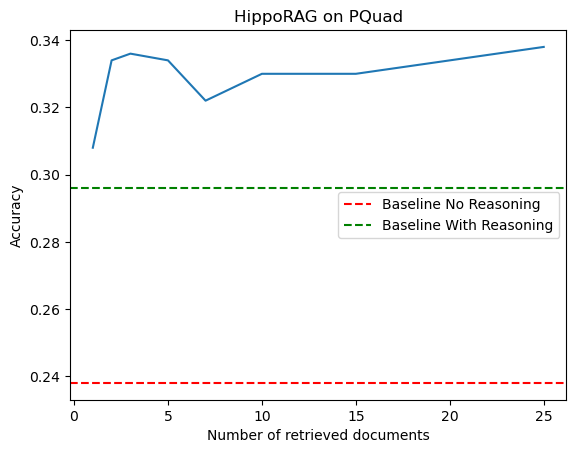

In [60]:
# plot the results
from matplotlib import pyplot as plt

plt.plot(accuracy.keys(), accuracy.values())
plt.xlabel('Number of retrieved documents')
plt.ylabel('Accuracy')
plt.title('HippoRAG on PQuad')

plt.axhline(y=baseline_acc_no_reasoning, color='r', linestyle='--', label='Baseline No Reasoning')
plt.axhline(y=baseline_acc_reasoning, color='g', linestyle='--', label='Baseline With Reasoning')
plt.legend()

plt.show()

## Fix metric for unanswerable questions

In [1]:
import pandas as pd

In [3]:
combined_results_different_numbers = pd.read_json('evaluated_results_no_reasoning_different_numbers.json')
df_different_numbers = {
    num: (pd.DataFrame((results).to_dict()).T)
    for num, results in combined_results_different_numbers.items()
}

accuracy_different_numbers_nan_filtered = {
    num: df_different_numbers[num][df_different_numbers[num]['answer'].notna()]['is_correct'].mean()
    for num in df_different_numbers
}

for num in accuracy_different_numbers_nan_filtered:
    print(f"Number of retrieved documents: {num} | Accuracy (NaN filtered): {accuracy_different_numbers_nan_filtered[num]:.4f}")

Number of retrieved documents: 1 | Accuracy (NaN filtered): 0.2995
Number of retrieved documents: 2 | Accuracy (NaN filtered): 0.3243
Number of retrieved documents: 3 | Accuracy (NaN filtered): 0.3317
Number of retrieved documents: 5 | Accuracy (NaN filtered): 0.3366
Number of retrieved documents: 7 | Accuracy (NaN filtered): 0.3292
Number of retrieved documents: 10 | Accuracy (NaN filtered): 0.3515
Number of retrieved documents: 15 | Accuracy (NaN filtered): 0.3564
Number of retrieved documents: 25 | Accuracy (NaN filtered): 0.3639


In [5]:
# load the baseline results
df_results_baseline_no_reasoning = pd.read_csv('../../Baseline/gpt/pqaud_evaluated_results.csv')
df_results_baseline_reasoning = pd.read_csv('../../Baseline/gpt/pquad_evaluated_results_reasoning.csv')

baseline_acc_no_reasoning_nan_filtered = df_results_baseline_no_reasoning[df_results_baseline_no_reasoning['answer'].notna()]['is_correct'].mean()
baseline_acc_reasoning_nan_filtered = df_results_baseline_reasoning[df_results_baseline_reasoning['answer'].notna()]['is_correct'].mean()
baseline_acc_no_reasoning_nan_filtered, baseline_acc_reasoning_nan_filtered

(0.21311475409836064, 0.22131147540983606)

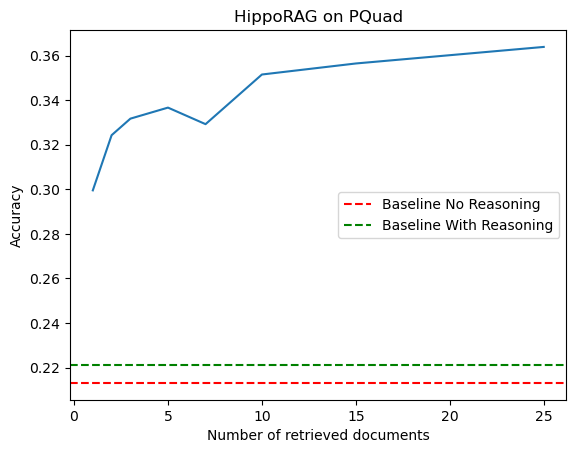

In [6]:
# plot the results
from matplotlib import pyplot as plt
plt.plot(accuracy_different_numbers_nan_filtered.keys(), accuracy_different_numbers_nan_filtered.values())
plt.xlabel('Number of retrieved documents')
plt.ylabel('Accuracy')
plt.title('HippoRAG on PQuad')

plt.axhline(y=baseline_acc_no_reasoning_nan_filtered, color='r', linestyle='--', label='Baseline No Reasoning')
plt.axhline(y=baseline_acc_reasoning_nan_filtered, color='g', linestyle='--', label='Baseline With Reasoning')
plt.legend()
plt.show()

**The results above are the real values, but for consistency with the KG-RAG report, we take the non answerable questions as a positive sample**

In [5]:
# set is_correct to True if the answer is NaN
df_results_baseline_reasoning['is_correct'] = df_results_baseline_reasoning.apply(
    lambda row: True if pd.isna(row['answer']) else row['is_correct'], axis=1
)
acc_base_with_nan_reasoning = df_results_baseline_reasoning['is_correct'].mean()

df_results_baseline_no_reasoning['is_correct'] = df_results_baseline_no_reasoning.apply(
    lambda row: True if pd.isna(row['answer']) else row['is_correct'], axis=1
)
acc_base_with_nan_no_reasoning = df_results_baseline_no_reasoning['is_correct'].mean()

print("Accuracy baseline with reasoning with NaN answers considered correct:", acc_base_with_nan_reasoning)
print("Accuracy baseline without reasoning with NaN answers considered correct:", acc_base_with_nan_no_reasoning)

Accuracy baseline with reasoning with NaN answers considered correct: 0.36666666666666664
Accuracy baseline without reasoning with NaN answers considered correct: 0.36


In [6]:
# set is_correct to True if the answer is NaN for different numbers of retrieved documents
accuracy_different_numbers_nan_filtered = {}
for num, _df in df_different_numbers.items():
    _df['is_correct'] = _df.apply(
        lambda row: True if pd.isna(row['answer']) else row['is_correct'], axis=1
    )
    acc_with_nan = _df['is_correct'].mean()
    accuracy_different_numbers_nan_filtered[num] = acc_with_nan
    print(f"Number of retrieved documents: {num} | Accuracy (with NaN as correct): {acc_with_nan:.4f}")

Number of retrieved documents: 1 | Accuracy (with NaN as correct): 0.4340
Number of retrieved documents: 2 | Accuracy (with NaN as correct): 0.4540
Number of retrieved documents: 3 | Accuracy (with NaN as correct): 0.4600
Number of retrieved documents: 5 | Accuracy (with NaN as correct): 0.4640
Number of retrieved documents: 7 | Accuracy (with NaN as correct): 0.4580
Number of retrieved documents: 10 | Accuracy (with NaN as correct): 0.4760
Number of retrieved documents: 15 | Accuracy (with NaN as correct): 0.4800
Number of retrieved documents: 25 | Accuracy (with NaN as correct): 0.4860


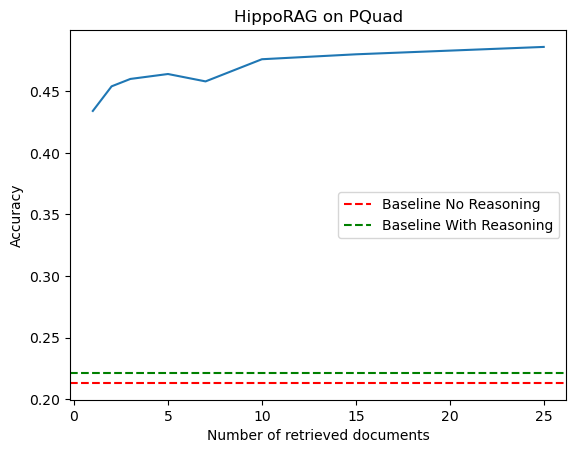

In [9]:
# plot the results
from matplotlib import pyplot as plt
plt.plot(accuracy_different_numbers_nan_filtered.keys(), accuracy_different_numbers_nan_filtered.values())
plt.xlabel('Number of retrieved documents')
plt.ylabel('Accuracy')
plt.title('HippoRAG on PQuad')

plt.axhline(y=baseline_acc_no_reasoning_nan_filtered, color='r', linestyle='--', label='Baseline No Reasoning')
plt.axhline(y=baseline_acc_reasoning_nan_filtered, color='g', linestyle='--', label='Baseline With Reasoning')
plt.legend()
plt.show()